In [3]:
import pandas as pd
import os

# 각 파일의 실제 경로를 지정 (GS_final.xlsx는 지정된 절대경로 사용)
files_and_paths = {
    "GS_final.xlsx": r"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\GS_final.xlsx",
    "KT_final.xlsx": "./전치리/KT_final.xlsx",
    "SKT_final.xlsx": "./전치리/SKT_final.xlsx",
    "롯데_final.xlsx": "./전치리/롯데_final.xlsx"
}

# 파일마다 info 출력
for file, file_path in files_and_paths.items():
    print(f"===== {file} =====")
    try:
        df = pd.read_excel(file_path)
        print(df.info())
        print()  # 줄바꿈
    except Exception as e:
        print(f"Error loading {file}: {e}\n")


===== GS_final.xlsx =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   content_id       267 non-null    int64         
 1   datetime         267 non-null    datetime64[ns]
 2   post_sentiment   267 non-null    object        
 3   post_s           187 non-null    float64       
 4   cmt_s_mean       187 non-null    float64       
 5   abs_sent_gap     187 non-null    float64       
 6   aligned_cnt_3h   187 non-null    float64       
 7   aligned_cnt_6h   187 non-null    float64       
 8   aligned_cnt_9h   187 non-null    float64       
 9   viewCount        22 non-null     float64       
 10  likeCount        22 non-null     float64       
 11  comment_cnt      187 non-null    float64       
 12  subscriberCount  22 non-null     float64       
 13  언론사              165 non-null    object        
 14  content         

In [1]:

import pandas as pd
import numpy as np
import os

# ------------------------------------------------------------
# 1️⃣ L지수 계산 함수 정의 (유튜브 제외)
#  + 기존 df에 L 및 Lnorm만 병합하여 반환
# ------------------------------------------------------------
def calc_L(df, group_col="언론사", beta=0.9, return_with_df=False):
    """
    L지수 계산 함수
    group_col: 그룹 기준 (언론사)
    beta: L_core (R,E,T) 비중 (coverage 보조 1-beta)
    return_with_df: True이면, 주요 L/R/E/T/Lnorm 컬럼을 원본 df에 병합하여 반환
    """

    # ===== 기본 결측 처리 =====
    df = df.copy()

    # 데이터 타입 변환: float로 변환할 수 없는 값은 NaN 처리
    for col in ['comment_cnt', 'aligned_cnt_3h', 'aligned_cnt_6h', 'aligned_cnt_9h']:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # ===== R (Reach): 댓글 수 로그 =====
    df['R'] = np.log1p(df['comment_cnt'])

    # ===== E (Engagement): 감정 일치율 =====
    comment_sum = df['comment_cnt'].replace(0, np.nan)
    df['E'] = (
        (df['aligned_cnt_9h'])
        / comment_sum
    ).fillna(0)

    # ===== T (Timeliness): 최초 보도 순위 =====
    # datetime 컬럼 문자형인 경우 오류방지: 변환
    if not np.issubdtype(df['datetime'].dtype, np.datetime64):
        df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
    first_report = (
        df.groupby(group_col)['datetime'].min()
        .reset_index(name='first_datetime')
        .sort_values('first_datetime')
        .reset_index(drop=True)
    )
    first_report['rank'] = np.arange(1, len(first_report) + 1)
    N = len(first_report)
    first_report['T'] = 1 - ((first_report['rank'] - 1) / (N - 1 if N > 1 else 1))
    df = df.merge(first_report[[group_col, 'T']], on=group_col, how='left')

    # ===== 그룹별 평균 및 건수 집계 =====
    media_L = (
        df.groupby(group_col)
        .agg(
            R=('R', 'mean'),
            E=('E', 'mean'),
            T=('T', 'first'),
            article_count=('content_id', 'count')
        )
        .reset_index()
    )

    # ===== λ_coverage: 기사 수 기반 (최대값 정규화) =====
    max_articles = media_L['article_count'].max()
    if pd.isnull(max_articles) or max_articles == 0:
        media_L['λ_coverage'] = 0
    else:
        media_L['λ_coverage'] = media_L['article_count'] / max_articles

    # ===== L_core & L 최종 계산 =====
    media_L['L_core'] = 0.35*media_L['R'] + 0.35*media_L['E'] + 0.30*media_L['T']
    media_L['L'] = beta*media_L['L_core'] + (1-beta)*media_L['λ_coverage']

    # ===== L 사후 정규화 =====
    L_min = media_L['L'].min()
    L_max = media_L['L'].max()
    if L_max != L_min:
        media_L['Lnorm'] = (media_L['L'] - L_min) / (L_max - L_min)
    else:
        media_L['Lnorm'] = 0

    # ===== 정렬 =====
    media_L = media_L.sort_values('L', ascending=False).reset_index(drop=True)

    if return_with_df:
        # 기존 df에 L, Lnorm 뿐만 아니라 R, E, T 까지 병합
        target_cols = [group_col, 'L', 'Lnorm', 'R', 'E', 'T']
        df = df.merge(media_L[target_cols], on=group_col, how='left')
        return media_L, df
    else:
        return media_L

# ------------------------------------------------------------
# 2️⃣ 여러 이슈별로 L지수와 Lnorm을 원본 파일에 병합하여 저장
# ------------------------------------------------------------

# 이슈별 파일 경로 정의
issue_files = {
    "GS": r"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\GS_final.xlsx",
    "KT": r"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\KT_final.xlsx",
    "SKT": r"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\SKT_final.xlsx",
    "롯데": r"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\롯데_final.xlsx"
}

output_dir = os.path.join("전처리", "결과")
os.makedirs(output_dir, exist_ok=True)

for issue, file_path in issue_files.items():
    # 원본 파일 불러오기
    df = pd.read_excel(file_path)

    # 네이버만 사용 (채널 컬럼 없을 수도 있음)
    if 'channel' in df.columns:
        df_naver = df[df['channel'] == '네이버'].copy()
    else:
        df_naver = df.copy()

    # ~~~~~~~~~~ 이슈 해결: 수치 컬럼이 문자열일 경우 float로 변환 ~~~~~~~~~~
    for col in ['comment_cnt', 'aligned_cnt_3h', 'aligned_cnt_6h', 'aligned_cnt_9h']:
        df_naver[col] = pd.to_numeric(df_naver[col], errors='coerce').fillna(0)

    # L지수 계산 및 병합
    media_L, df_naver_with_L = calc_L(df_naver, group_col="언론사", beta=0.9, return_with_df=True)
    # 기존 원본에 L/Lnorm/R/E/T merge (없으면 값은 NaN)
    merged_df = df.merge(
        media_L[['언론사', 'L', 'Lnorm', 'R', 'E', 'T']],
        on='언론사', how='left'
    )
    # 결과 덮어쓰기 저장
    save_path = file_path.replace('.xlsx', '_with_L.xlsx')
    merged_df.to_excel(save_path, index=False)
    print(f"✅ [{issue}] L/Lnorm/R/E/T 포함된 원본 저장 → {save_path}")



✅ [GS] L/Lnorm/R/E/T 포함된 원본 저장 → C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\GS_final_with_L.xlsx
✅ [KT] L/Lnorm/R/E/T 포함된 원본 저장 → C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\KT_final_with_L.xlsx
✅ [SKT] L/Lnorm/R/E/T 포함된 원본 저장 → C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\SKT_final_with_L.xlsx
✅ [롯데] L/Lnorm/R/E/T 포함된 원본 저장 → C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\롯데_final_with_L.xlsx


In [26]:
lotte_file = r"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\롯데_final_with_L.xlsx"
df = pd.read_excel(lotte_file)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1173 entries, 0 to 1172
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   content_id       1173 non-null   int64         
 1   datetime         1173 non-null   datetime64[ns]
 2   post_sentiment   1173 non-null   object        
 3   post_s           834 non-null    float64       
 4   cmt_s_mean       834 non-null    float64       
 5   abs_sent_gap     834 non-null    float64       
 6   aligned_cnt_3h   834 non-null    float64       
 7   aligned_cnt_6h   834 non-null    object        
 8   aligned_cnt_9h   834 non-null    float64       
 9   viewCount        498 non-null    float64       
 10  likeCount        498 non-null    float64       
 11  comment_cnt      834 non-null    float64       
 12  subscriberCount  498 non-null    float64       
 13  언론사              336 non-null    object        
 14  content          335 non-null    object 

In [3]:
import pandas as pd
import numpy as np
import os

# ------------------------------------------------------------
# ✅ YouTube L지수 계산 (현재 데이터 컬럼 구조 기준)
# ------------------------------------------------------------
def calc_L_youtube_from_combined(df):
    """
    df: 전처리 통합 데이터 (유튜브/네이버 혼합)
    - channel == '유튜브' 인 행만 계산
    - L지수 계산 후 기존 컬럼은 그대로 두고 E, S, T, L, Lnorm 추가
    """

    # 🎯 유튜브 데이터만 필터
    df_youtube = df[df['channel'] == '유튜브'].copy()
    if df_youtube.empty:
        print("⚠️ 유튜브 데이터 없음 — 건너뜀")
        return df

    # --------------------------------------------------------
    # 1️⃣ 결측치 및 타입 변환
    # --------------------------------------------------------
    for col in ['likeCount', 'comment_cnt', 'viewCount', 'subscriberCount']:
        df_youtube[col] = pd.to_numeric(df_youtube[col], errors='coerce').fillna(0)

    if not np.issubdtype(df_youtube['datetime'].dtype, np.datetime64):
        df_youtube['datetime'] = pd.to_datetime(df_youtube['datetime'], errors='coerce')

    # --------------------------------------------------------
    # 2️⃣ E (Engagement) = (like + comment) / max(view, 1)
    # --------------------------------------------------------
    df_youtube['E'] = (df_youtube['likeCount'] + df_youtube['comment_cnt']) / df_youtube['viewCount'].replace(0, 1)

    # --------------------------------------------------------
    # 3️⃣ S (Source Influence)
    #     = log1p(0.7*subscriberCount + 0.3*channel_total_videos)
    # --------------------------------------------------------
    df_youtube['channel_total_videos'] = df_youtube.groupby('channelTitle')['content_id'].transform('count')
    df_youtube['S'] = np.log1p(0.7 * df_youtube['subscriberCount'] + 0.3 * df_youtube['channel_total_videos'])

    # --------------------------------------------------------
    # 4️⃣ T (Timeliness)
    #     = 1 - (upload_rank - 1) / (channel_total_videos - 1)
    # --------------------------------------------------------
    df_youtube = df_youtube.sort_values(by=['channelTitle', 'datetime'], ascending=[True, True])
    df_youtube['upload_rank'] = df_youtube.groupby('channelTitle')['datetime'].rank(method='first')
    df_youtube['T'] = 1 - (df_youtube['upload_rank'] - 1) / (df_youtube['channel_total_videos'] - 1).replace(0, 1)

    # --------------------------------------------------------
    # 5️⃣ L = 0.45E + 0.35S + 0.20T
    # --------------------------------------------------------
    df_youtube['L'] = 0.45 * df_youtube['E'] + 0.35 * df_youtube['S'] + 0.20 * df_youtube['T']

    # --------------------------------------------------------
    # 6️⃣ Lnorm (정규화)
    # --------------------------------------------------------
    L_min, L_max = df_youtube['L'].min(), df_youtube['L'].max()
    df_youtube['Lnorm'] = (df_youtube['L'] - L_min) / (L_max - L_min) if L_max != L_min else 0

    # --------------------------------------------------------
    # 7️⃣ 원본 데이터에 병합 (channelTitle 기준)
    # --------------------------------------------------------
    df = df.merge(
        df_youtube[['channelTitle', 'E', 'S', 'T', 'L', 'Lnorm']],
        on='channelTitle',
        how='left'
    )

    return df


# ------------------------------------------------------------
# ✅ 파일 루프 실행 예시
# ------------------------------------------------------------
issue_files = {
    "GS":  r"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\GS_final_with_L.xlsx",
    "KT":  r"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\KT_final_with_L.xlsx",
    "SKT": r"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\SKT_final_with_L.xlsx",
    "롯데": r"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\롯데_final_with_L.xlsx",
}

for issue, file_path in issue_files.items():
    df = pd.read_excel(file_path)
    df_with_L = calc_L_youtube_from_combined(df)
    save_path = file_path.replace('.xlsx', '_with_L.xlsx')
    df_with_L.to_excel(save_path, index=False)
    print(f"✅ [{issue}] L지수 컬럼 추가 완료 → {save_path}")


✅ [GS] L지수 컬럼 추가 완료 → C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\GS_final_with_L_with_L.xlsx
✅ [KT] L지수 컬럼 추가 완료 → C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\KT_final_with_L_with_L.xlsx
✅ [SKT] L지수 컬럼 추가 완료 → C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\SKT_final_with_L_with_L.xlsx
✅ [롯데] L지수 컬럼 추가 완료 → C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\롯데_final_with_L_with_L.xlsx


In [4]:
import pandas as pd
import os

for issue in ["GS", "KT", "SKT", "롯데"]:
    f_path = fr"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\{issue}_final_with_L_with_L.xlsx"
    df = pd.read_excel(f_path)

    def merge_columns(cols):
        """존재하는 모든 컬럼을 평균으로 병합 (NaN 제외)"""
        existing = [df[c] for c in cols if c in df.columns]
        if not existing:
            return pd.Series([None] * len(df))
        merged = pd.concat(existing, axis=1).mean(axis=1, skipna=True)
        return merged

    # 존재하는 컬럼 전부 합쳐서 평균 병합
    l_series     = merge_columns(['L', 'L_x', 'L_y'])
    lnorm_series = merge_columns(['Lnorm', 'Lnorm_x', 'Lnorm_y'])
    e_series     = merge_columns(['E', 'E_x', 'E_y'])
    t_series     = merge_columns(['T', 'T_x', 'T_y'])

    # 기존 L/E/T 계열 컬럼 삭제
    drop_cols = []
    for base in ['L', 'Lnorm', 'E', 'T']:
        drop_cols += [c for c in df.columns if c == base or c.startswith(f"{base}_")]

    df_dropped = df.drop(columns=drop_cols, errors='ignore')

    # 기존 데이터 유지 + 병합 컬럼 추가
    out_df = df_dropped.copy()
    out_df['L'] = l_series
    out_df['Lnorm'] = lnorm_series
    out_df['E'] = e_series
    out_df['T'] = t_series
    out_df.insert(0, 'issue', issue)

    export_path = f_path.replace('_with_L_with_L.xlsx', '_merged_L_Lnorm_E_T.xlsx')
    out_df.to_excel(export_path, index=False)
    print(f"✅ [{issue}] 모든 존재 컬럼 병합 완료 → {export_path}")


✅ [GS] 모든 존재 컬럼 병합 완료 → C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\GS_final_merged_L_Lnorm_E_T.xlsx
✅ [KT] 모든 존재 컬럼 병합 완료 → C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\KT_final_merged_L_Lnorm_E_T.xlsx
✅ [SKT] 모든 존재 컬럼 병합 완료 → C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\SKT_final_merged_L_Lnorm_E_T.xlsx
✅ [롯데] 모든 존재 컬럼 병합 완료 → C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\롯데_final_merged_L_Lnorm_E_T.xlsx


In [21]:
import pandas as pd

issue = "GS"  # 원하는 이슈명을 여기에 입력하세요 (예: "KT", "SKT", "롯데")
file_path = fr"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\{issue}_final_merged_L_Lnorm_E_T.xlsx"
df = pd.read_excel(file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   issue            287 non-null    object        
 1   content_id       287 non-null    int64         
 2   datetime         287 non-null    datetime64[ns]
 3   post_sentiment   287 non-null    object        
 4   post_s           207 non-null    float64       
 5   cmt_s_mean       207 non-null    float64       
 6   abs_sent_gap     207 non-null    float64       
 7   aligned_cnt_3h   207 non-null    float64       
 8   aligned_cnt_6h   207 non-null    float64       
 9   aligned_cnt_9h   207 non-null    float64       
 10  viewCount        36 non-null     float64       
 11  likeCount        36 non-null     float64       
 12  comment_cnt      207 non-null    float64       
 13  subscriberCount  36 non-null     float64       
 14  언론사              171 non-null    object   

In [27]:
import pandas as pd

issue = "GS"  # 예: "KT", "SKT", "롯데"
file_path = fr"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\{issue}_final_merged_L_Lnorm_E_T.xlsx"

df = pd.read_excel(file_path)

# ===============================
# 📗 네이버: 언론사별 최대 L 1건만
# ===============================
df_naver = df[df["channel"] == "네이버"].dropna(subset=["L"])
df_naver_sorted = (
    df_naver.sort_values(by="L", ascending=False)
    .drop_duplicates(subset=["언론사"], keep="first")  # ✅ 중복 제거
    [["언론사", "L"]]
    .reset_index(drop=True)
)

print("📗 [네이버] L 내림차순 (언론사 중복 제거 후 상위 10개)\n", df_naver_sorted.head(10), "\n")

# ===============================
# 📺 유튜브: 채널명별 최대 L 1건만
# ===============================
df_youtube = df[df["channel"] == "유튜브"].dropna(subset=["L"])
df_youtube_sorted = (
    df_youtube.sort_values(by="L", ascending=False)
    .drop_duplicates(subset=["channelTitle"], keep="first")  # ✅ 중복 제거
    [["channelTitle", "L"]]
    .reset_index(drop=True)
)

print("📺 [유튜브] L 내림차순 (채널 중복 제거 후 상위 10개)\n", df_youtube_sorted.head(10))


📗 [네이버] L 내림차순 (언론사 중복 제거 후 상위 10개)
     언론사         L
0  매일경제  3.021624
1   YTN  3.011154
2   뉴스1  2.929477
3  세계일보  2.833650
4  문화일보  2.669202
5  한국일보  2.261405
6  연합뉴스  2.174401
7  동아일보  2.010531
8   블로터  1.911872
9   머니S  1.834362 

📺 [유튜브] L 내림차순 (채널 중복 제거 후 상위 10개)
    channelTitle         L
0       MBCNEWS  5.550876
1           YTN  5.491244
2        SBS 뉴스  5.487312
3     JTBC News  5.467851
4    뉴스TVCHOSUN  5.301947
5        이데일리TV  4.541170
6          이포커스  4.301971
7  YTN 사이언스 투데이  4.182624
8        알파경제TV  4.077808
9      메디컬투데이TV  3.762078


🔹 이슈: GS
📗 [네이버] L 내림차순 (언론사 중복 제거 후 상위 10개, Lnorm 같이 표시)
    언론사     L  Lnorm
0   YTN  3.01   0.83
1  매일경제  2.99   0.82
2   뉴스1  2.93   0.72
3  세계일보  2.81   0.66
4  문화일보  2.67   0.48
5  한국일보  2.18   0.57
6  연합뉴스  2.12   0.49
7   블로터  1.91   0.23
8   머니S  1.74   0.51
9  동아일보  1.70   0.39 

📺 [유튜브] L 내림차순 (채널 중복 제거 후 상위 10개, Lnorm 같이 표시)
   channelTitle     L  Lnorm
0       MBCNEWS  5.55   1.00
1           YTN  5.49   0.98
2        SBS 뉴스  5.49   0.98
3     JTBC News  5.47   0.97
4    뉴스TVCHOSUN  5.30   0.91
5        이데일리TV  4.54   0.65
6          이포커스  4.30   0.57
7  YTN 사이언스 투데이  4.18   0.53
8        알파경제TV  4.08   0.49
9      메디컬투데이TV  3.76   0.39 

✅ 저장 완료 → C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\L정렬결과\GS_naver_Lsorted.xlsx
✅ 저장 완료 → C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\L정렬결과\GS_youtube_Lsorted.xlsx



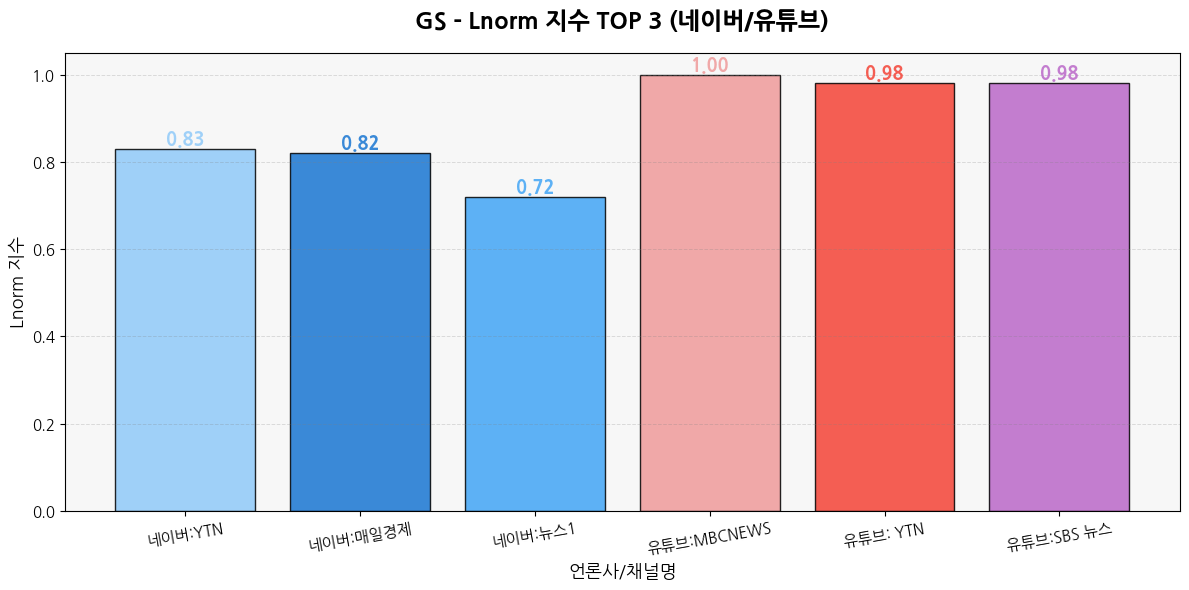

🔹 이슈: KT
📗 [네이버] L 내림차순 (언론사 중복 제거 후 상위 10개, Lnorm 같이 표시)
       언론사     L  Lnorm
0  CJB청주방송  2.13   1.00
1      채널A  1.29   0.60
2      한겨레  0.91   0.42
3      MBN  0.83   0.39
4    오마이뉴스  0.82   0.38
5     매일신문  0.79   0.37
6     경향신문  0.77   0.36
7   강원도민일보  0.77   0.36
8     연합뉴스  0.75   0.35
9     한국일보  0.71   0.33 

📺 [유튜브] L 내림차순 (채널 중복 제거 후 상위 10개, Lnorm 같이 표시)
  channelTitle     L  Lnorm
0      MBCNEWS  5.55   1.00
1          YTN  5.49   0.99
2       SBS 뉴스  5.48   0.99
3    JTBC News  5.46   0.98
4         슈카월드  5.37   0.97
5     채널A News  5.36   0.96
6     KBS News  5.36   0.96
7   뉴스TVCHOSUN  5.30   0.95
8     MBN News  5.24   0.94
9       연합뉴스TV  5.18   0.93 

✅ 저장 완료 → C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\L정렬결과\KT_naver_Lsorted.xlsx
✅ 저장 완료 → C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\L정렬결과\KT_youtube_Lsorted.xlsx



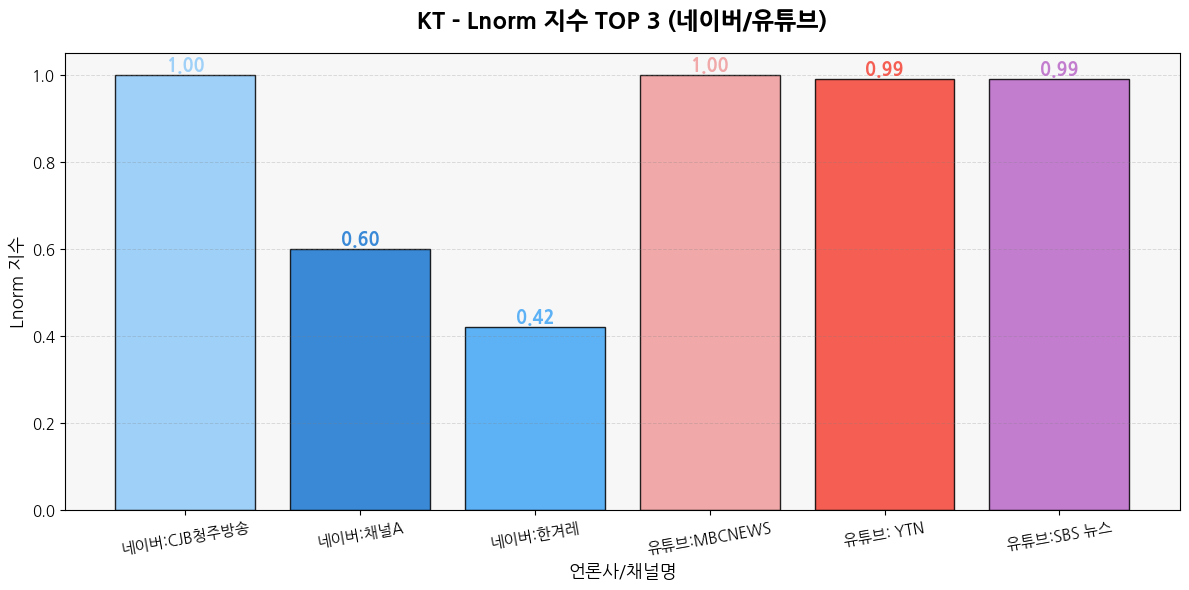

🔹 이슈: SKT
📗 [네이버] L 내림차순 (언론사 중복 제거 후 상위 10개, Lnorm 같이 표시)
      언론사     L  Lnorm
0    주간동아  1.54   1.00
1    강원일보  1.51   0.98
2  매경이코노미  1.49   0.97
3   한겨레21  1.46   0.95
4    서울신문  1.43   0.93
5   미디어오늘  1.43   0.93
6     신동아  1.31   0.85
7    조선일보  1.12   0.73
8     한겨레  1.07   0.70
9    조선비즈  1.05   0.68 

📺 [유튜브] L 내림차순 (채널 중복 제거 후 상위 10개, Lnorm 같이 표시)
  channelTitle     L  Lnorm
0      MBCNEWS  5.54   1.00
1          YTN  5.49   0.99
2          이용원  5.49   0.99
3       SBS 뉴스  5.48   0.99
4    JTBC News  5.46   0.98
5     KBS News  5.35   0.96
6     채널A News  5.33   0.96
7   뉴스TVCHOSUN  5.30   0.95
8      ITSub잇섭  5.28   0.95
9         1분미만  5.25   0.94 

✅ 저장 완료 → C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\L정렬결과\SKT_naver_Lsorted.xlsx
✅ 저장 완료 → C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\L정렬결과\SKT_youtube_Lsorted.xlsx



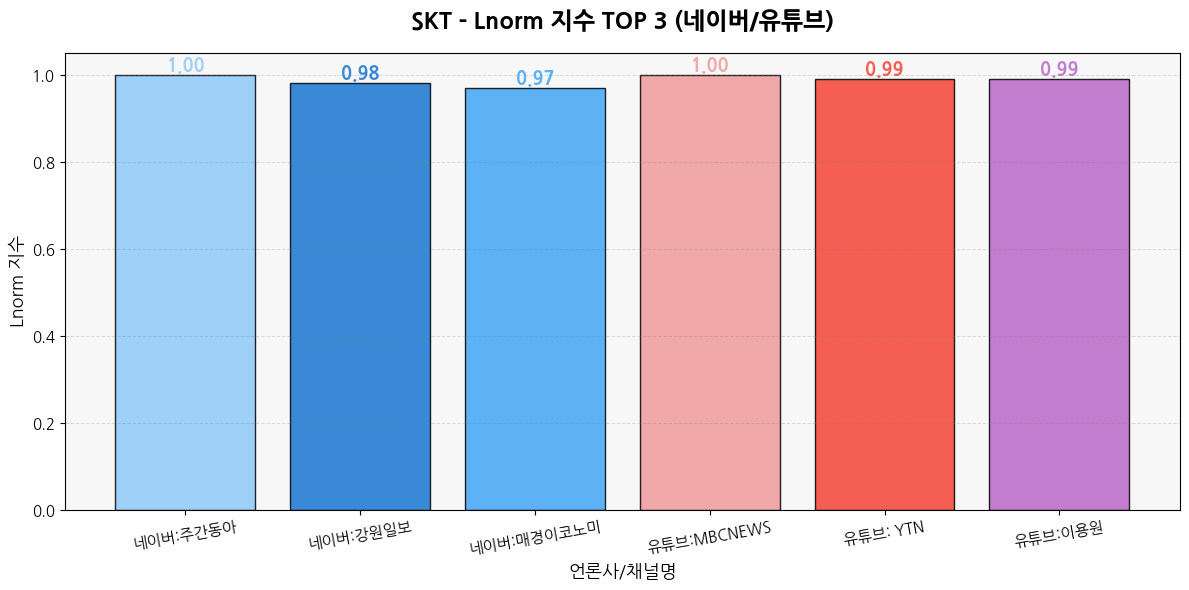

🔹 이슈: 롯데
📗 [네이버] L 내림차순 (언론사 중복 제거 후 상위 10개, Lnorm 같이 표시)
      언론사     L  Lnorm
0    경향신문  1.41   1.00
1    동아일보  1.02   0.72
2  매경이코노미  0.93   0.66
3    강원일보  0.88   0.62
4    한국일보  0.76   0.54
5     뉴시스  0.75   0.53
6    국민일보  0.73   0.52
7    주간조선  0.68   0.48
8    연합뉴스  0.65   0.46
9    매일경제  0.63   0.45 

📺 [유튜브] L 내림차순 (채널 중복 제거 후 상위 10개, Lnorm 같이 표시)
  channelTitle     L  Lnorm
0      MBCNEWS  5.55   1.00
1          YTN  5.49   0.99
2       SBS 뉴스  5.48   0.99
3    JTBC News  5.46   0.98
4     KBS News  5.35   0.96
5     채널A News  5.34   0.96
6   뉴스TVCHOSUN  5.30   0.95
7     [팟빵] 매불쇼  5.29   0.95
8     MBN News  5.24   0.94
9       연합뉴스TV  5.18   0.93 

✅ 저장 완료 → C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\L정렬결과\롯데_naver_Lsorted.xlsx
✅ 저장 완료 → C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\L정렬결과\롯데_youtube_Lsorted.xlsx



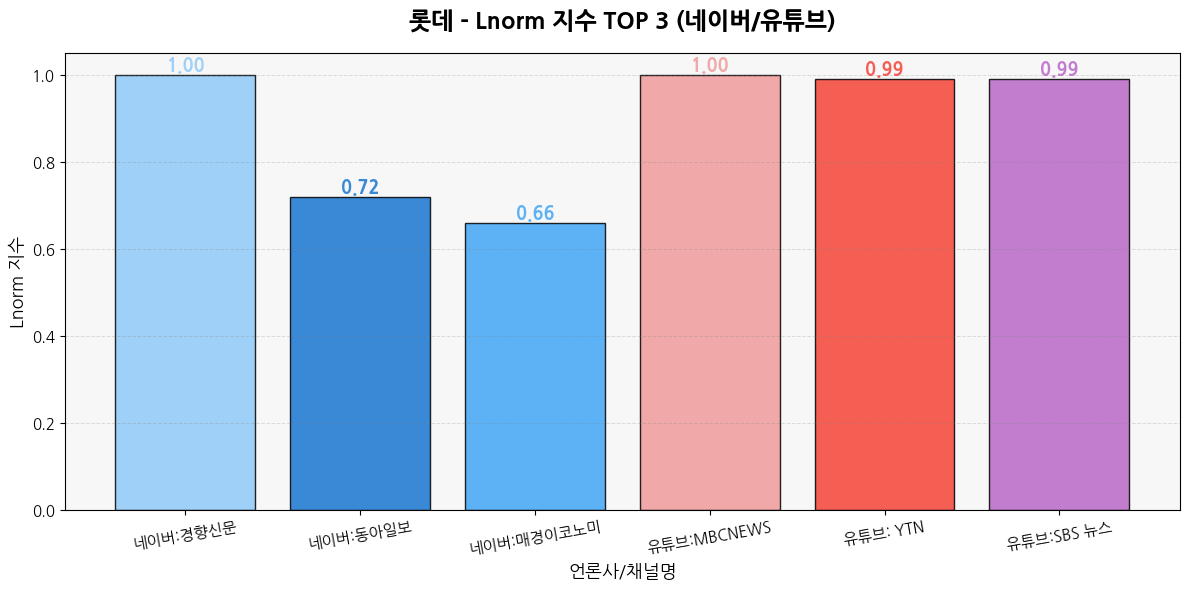

In [7]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# ▣ 한글 깨짐 방지: 나눔고딕 폰트 사용 (설치 안되어 있으면 기본 폰트로 fallback)
def set_korean_font():
    try:
        font_paths = fm.findSystemFonts(fontpaths=None, fontext='ttf')
        nanum_fonts = [fp for fp in font_paths if 'NanumGothic' in fp or 'Malgun' in fp or 'AppleGothic' in fp]
        if nanum_fonts:
            plt.rcParams['font.family'] = fm.FontProperties(fname=nanum_fonts[0]).get_name()
        else:
            # 윈도우(맑은고딕), Mac(AppleGothic) 기본 폰트
            import platform
            if platform.system() == 'Windows':
                plt.rcParams['font.family'] = 'Malgun Gothic'
            elif platform.system() == 'Darwin':
                plt.rcParams['font.family'] = 'AppleGothic'
            else:
                plt.rcParams['font.family'] = 'NanumGothic'
        plt.rcParams['axes.unicode_minus'] = False
    except Exception as e:
        print("💡 한글 폰트 설정 오류:", e)
set_korean_font()

issues = ["GS", "KT", "SKT", "롯데"]
base_path = r"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리"

for issue in issues:
    print("=" * 80)
    print(f"🔹 이슈: {issue}")
    print("=" * 80)

    file_path = os.path.join(base_path, f"{issue}_final_merged_L_Lnorm_E_T.xlsx")

    if not os.path.exists(file_path):
        print(f"⚠️ 파일 없음: {file_path}")
        continue

    df = pd.read_excel(file_path)

    # ===============================
    # 📗 네이버: 언론사별 최대 L 1건만 (+ Lnorm 함께 보여줌)
    # ===============================
    df_naver = df[df["channel"] == "네이버"].dropna(subset=["L"])
    df_naver_sorted = (
        df_naver.sort_values(by="L", ascending=False)
        .drop_duplicates(subset=["언론사"], keep="first")
        [["언론사", "L", "Lnorm"]]
        .reset_index(drop=True)
    )
    # 소수 둘째짜리 까지 포맷팅
    df_naver_sorted["L"] = df_naver_sorted["L"].apply(lambda x: round(x, 2))
    df_naver_sorted["Lnorm"] = df_naver_sorted["Lnorm"].apply(lambda x: round(x, 2))

    print("📗 [네이버] L 내림차순 (언론사 중복 제거 후 상위 10개, Lnorm 같이 표시)")
    print(df_naver_sorted.head(10), "\n")

    # ===============================
    # 📺 유튜브: 채널명별 최대 L 1건만 (+ Lnorm 함께 보여줌)
    # ===============================
    df_youtube = df[df["channel"] == "유튜브"].dropna(subset=["L"])
    df_youtube_sorted = (
        df_youtube.sort_values(by="L", ascending=False)
        .drop_duplicates(subset=["channelTitle"], keep="first")
        [["channelTitle", "L", "Lnorm"]]
        .reset_index(drop=True)
    )
    df_youtube_sorted["L"] = df_youtube_sorted["L"].apply(lambda x: round(x, 2))
    df_youtube_sorted["Lnorm"] = df_youtube_sorted["Lnorm"].apply(lambda x: round(x, 2))

    print("📺 [유튜브] L 내림차순 (채널 중복 제거 후 상위 10개, Lnorm 같이 표시)")
    print(df_youtube_sorted.head(10), "\n")

    # ===============================
    # 💾 결과 저장 (선택사항: Lnorm 포함하여 저장)
    # ===============================
    export_dir = os.path.join(base_path, "L정렬결과")
    os.makedirs(export_dir, exist_ok=True)

    naver_path = os.path.join(export_dir, f"{issue}_naver_Lsorted.xlsx")
    youtube_path = os.path.join(export_dir, f"{issue}_youtube_Lsorted.xlsx")

    df_naver_sorted.to_excel(naver_path, index=False)
    df_youtube_sorted.to_excel(youtube_path, index=False)

    print(f"✅ 저장 완료 → {naver_path}")
    print(f"✅ 저장 완료 → {youtube_path}\n")

    # ===============================
    # 추가: Lnorm 탑 3 그래프 시각화(유튜브/네이버)
    # 아름다운 색상, 한글깨짐 방지
    # ===============================
    top3_naver = df_naver_sorted.head(3).copy()
    top3_youtube = df_youtube_sorted.head(3).copy()

    # 이름 라벨 맞춤
    naver_labels = [f"네이버:{name}" for name in top3_naver["언론사"]]
    youtube_labels = [f"유튜브:{name}" for name in top3_youtube["channelTitle"]]
    labels = naver_labels + youtube_labels
    Lnorm_values = list(top3_naver["Lnorm"]) + list(top3_youtube["Lnorm"])

    # 아름다운 색상 조합(Pastel 또는 ColorBlind Friendly)
    palette = [
        "#90caf9", "#1976d2", "#42a5f5",   # 블루 계열(네이버)
        "#ef9a9a", "#f44336", "#ba68c8"    # 레드·바이올렛(유튜브)
    ]
    naver_colors = palette[:3]
    youtube_colors = palette[3:6]
    bar_colors = naver_colors + youtube_colors

    plt.figure(figsize=(12, 6))
    bars = plt.bar(labels, Lnorm_values, color=bar_colors, edgecolor='black', alpha=0.85)

    # 서브 타이틀
    plt.title(f"{issue} - Lnorm 지수 TOP 3 (네이버/유튜브)", fontsize=17, fontweight="bold", pad=18)
    plt.ylabel("Lnorm 지수", fontsize=13)
    plt.xlabel("언론사/채널명", fontsize=13)

    # X축 라벨 스타일
    plt.xticks(fontsize=11, rotation=10)
    plt.yticks(fontsize=11)

    # 값 레이블 (소수 둘째자리까지 표기)
    for bar in bars:
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f'{bar.get_height():.2f}',
            ha='center',
            va='bottom',
            fontsize=13,
            fontweight='bold',
            color=bar.get_facecolor()
            if bar.get_facecolor() != (1.0, 1.0, 1.0, 1.0) else 'black',
            path_effects=[]
        )

    # 배경 꾸미기
    plt.gca().set_facecolor("#f7f7f7")
    plt.grid(axis='y', color="gray", linestyle="--", linewidth=0.7, alpha=0.25)

    # 레이아웃
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
import os

issues = ["GS", "KT", "SKT", "롯데"]

base_path = r"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리"

for issue in issues:
    print("=" * 80)
    print(f"🔹 이슈: {issue}")
    print("=" * 80)

    file_path = os.path.join(base_path, f"{issue}_final_merged_L_Lnorm_E_T.xlsx")

    if not os.path.exists(file_path):
        print(f"⚠️ 파일 없음: {file_path}")
        continue

    df = pd.read_excel(file_path)

    # ===============================
    # 📗 네이버: 언론사별 최대 L 1건만 (+ Lnorm 함께 보여줌)
    # ===============================
    df_naver = df[df["channel"] == "네이버"].dropna(subset=["L"])
    df_naver_sorted = (
        df_naver.sort_values(by="L", ascending=False)
        .drop_duplicates(subset=["언론사"], keep="first")
        [["언론사", "L", "Lnorm"]]
        .reset_index(drop=True)
    )

    print("📗 [네이버] L 내림차순 (언론사 중복 제거 후 상위 10개, Lnorm 같이 표시)")
    print(df_naver_sorted.head(10), "\n")

    # ===============================
    # 📺 유튜브: 채널명별 최대 L 1건만 (+ Lnorm 함께 보여줌)
    # ===============================
    df_youtube = df[df["channel"] == "유튜브"].dropna(subset=["L"])
    df_youtube_sorted = (
        df_youtube.sort_values(by="L", ascending=False)
        .drop_duplicates(subset=["channelTitle"], keep="first")
        [["channelTitle", "L", "Lnorm"]]
        .reset_index(drop=True)
    )

    print("📺 [유튜브] L 내림차순 (채널 중복 제거 후 상위 10개, Lnorm 같이 표시)")
    print(df_youtube_sorted.head(10), "\n")

    # ===============================
    # 💾 결과 저장 (선택사항: Lnorm 포함하여 저장)
    # ===============================
    export_dir = os.path.join(base_path, "L정렬결과")
    os.makedirs(export_dir, exist_ok=True)

    naver_path = os.path.join(export_dir, f"{issue}_naver_Lsorted.xlsx")
    youtube_path = os.path.join(export_dir, f"{issue}_youtube_Lsorted.xlsx")

    df_naver_sorted.to_excel(naver_path, index=False)
    df_youtube_sorted.to_excel(youtube_path, index=False)

    print(f"✅ 저장 완료 → {naver_path}")
    print(f"✅ 저장 완료 → {youtube_path}\n")


🔹 이슈: GS
📗 [네이버] L 내림차순 (언론사 중복 제거 후 상위 10개, Lnorm 같이 표시)
    언론사         L     Lnorm
0   YTN  3.011154  0.831278
1  매일경제  2.994243  0.820454
2   뉴스1  2.929477  0.724558
3  세계일보  2.807400  0.656272
4  문화일보  2.669202  0.475702
5  한국일보  2.176597  0.574094
6  연합뉴스  2.115339  0.494054
7   블로터  1.911872  0.228205
8   머니S  1.738112  0.507468
9  동아일보  1.695531  0.390761 

📺 [유튜브] L 내림차순 (채널 중복 제거 후 상위 10개, Lnorm 같이 표시)
   channelTitle         L     Lnorm
0       MBCNEWS  5.550876  1.000000
1           YTN  5.491244  0.979556
2        SBS 뉴스  5.487312  0.978208
3     JTBC News  5.467851  0.971536
4    뉴스TVCHOSUN  5.301947  0.914657
5        이데일리TV  4.541170  0.653830
6          이포커스  4.301971  0.571823
7  YTN 사이언스 투데이  4.182624  0.530906
8        알파경제TV  4.077808  0.494970
9      메디컬투데이TV  3.762078  0.386725 

✅ 저장 완료 → C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\L정렬결과\GS_naver_Lsorted.xlsx
✅ 저장 완료 → C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\L정렬결과\GS_youtube_Lsorted.xlsx

🔹 이슈: KT
📗 [네이버] L 내림

In [6]:
import glob

# 병합된 파일들이 있는 디렉토리 경로
merged_dir = r"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리"

# 처리할 파일 리스트 (GS, KT, SKT, 롯데)
company_files = [
    "GS_final_merged_L_Lnorm_E_T.xlsx",
    "KT_final_merged_L_Lnorm_E_T.xlsx",
    "SKT_final_merged_L_Lnorm_E_T.xlsx",
    "롯데_final_merged_L_Lnorm_E_T.xlsx"
]

for fname in company_files:
    fpath = os.path.join(merged_dir, fname)
    df = pd.read_excel(fpath)

    # 유튜브 데이터만 추출
    df_youtube = df[df["channel"] == "유튜브"].copy()
    # channel이 유튜브인 것 중 중복 제거 (channelTitle, L, Lnorm, etc 존재하면 우선순위 지정 가능)
    if "channelTitle" in df_youtube.columns:
        df_youtube_nodup = df_youtube.drop_duplicates(subset=["channelTitle"], keep="first")
    else:
        # channelTitle 열이 없으면 전체 유튜브 행에서 중복 제거
        df_youtube_nodup = df_youtube.drop_duplicates(keep="first")
    
    # 유튜브 아닌 데이터는 그대로
    df_not_youtube = df[df["channel"] != "유튜브"].copy()
    
    # 다시 병합
    df_merged = pd.concat([df_not_youtube, df_youtube_nodup], ignore_index=True)

    # 덮어쓰기 저장
    df_merged.to_excel(fpath, index=False)

    print(f"✅ 중복 제거 및 저장 → {fpath}")



✅ 중복 제거 및 저장 → C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\GS_final_merged_L_Lnorm_E_T.xlsx
✅ 중복 제거 및 저장 → C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\KT_final_merged_L_Lnorm_E_T.xlsx
✅ 중복 제거 및 저장 → C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\SKT_final_merged_L_Lnorm_E_T.xlsx
✅ 중복 제거 및 저장 → C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\롯데_final_merged_L_Lnorm_E_T.xlsx


In [16]:
import pandas as pd
import numpy as np
import os

# ------------------------------------------------------------
# 1️⃣ 데이터 불러오기 (4개 회사 모두)
# ------------------------------------------------------------
company_list = ["GS", "KT", "SKT", "롯데"]
dfs = {}
for company in company_list:
    file_path = rf"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\{company}_final_merged_L_Lnorm_E_T.xlsx"
    dfs[company] = pd.read_excel(file_path)
    print(f"✅ {company} 파일 불러옴 → {file_path}")

# ------------------------------------------------------------
# 2️⃣ L_flag 생성 및 값 보정, 저장 반복 (회사별로)
# ------------------------------------------------------------
output_dir = r"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리"
for company, df in dfs.items():
    # L_flag 생성: 유튜브·네이버 → 1, 트위터·블로그 → 0
    df["L_flag"] = np.where(df["channel"].isin(["유튜브", "네이버"]), 1, 0)
    
    # 트위터·블로그의 L, Lnorm 0으로 채우기
    for col in ["L", "Lnorm"]:
        if col in df.columns:
            df.loc[df["channel"].isin(["blog", "twitter"]), col] = 0
        else:
            print(f"⚠️ '{col}' 컬럼이 존재하지 않아 건너뜀 ({company})")
    
    # 결과 저장
    output_path = os.path.join(output_dir, f"{company}_with_Lflag.xlsx")
    df.to_excel(output_path, index=False, engine="openpyxl")
    
    print(f"✅ L값 보정 및 L_flag 생성 완료 → {output_path}")
    print(df[["channel", "L", "Lnorm", "L_flag"]].head())



✅ GS 파일 불러옴 → C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\GS_final_merged_L_Lnorm_E_T.xlsx
✅ KT 파일 불러옴 → C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\KT_final_merged_L_Lnorm_E_T.xlsx
✅ SKT 파일 불러옴 → C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\SKT_final_merged_L_Lnorm_E_T.xlsx
✅ 롯데 파일 불러옴 → C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\롯데_final_merged_L_Lnorm_E_T.xlsx
✅ L값 보정 및 L_flag 생성 완료 → C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\GS_with_Lflag.xlsx
  channel         L     Lnorm  L_flag
0     네이버  0.468599  0.601383       1
1     네이버  0.281042  0.356320       1
2     네이버  0.468599  0.601383       1
3     네이버  0.718862  0.928377       1
4     네이버  0.455905  0.584797       1
✅ L값 보정 및 L_flag 생성 완료 → C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\KT_with_Lflag.xlsx
  channel         L     Lnorm  L_flag
0     네이버  0.749937  0.350492       1
1     네이버  0.523064  0.244002       1
2     네이버  0.670884  0.313386       1
3     네이버  0.794570  0.371442       1
4     네이버  0.766670  0.358347       1
✅ L값 보정 

In [21]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# ------------------------------------------------------------
# 1️⃣ 데이터 불러오기
# ------------------------------------------------------------
company_list = ["GS", "KT", "SKT", "롯데"]
results = []

for company in company_list:
    file_path = rf"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\{company}_final_merged_L_Lnorm_E_T.xlsx"
    df = pd.read_excel(file_path)
    
    # 결측값 처리 (댓글·감정일치 컬럼이 비어있는 경우 0으로)
    df["comment_cnt"] = df["comment_cnt"].fillna(0)
    df["aligned_cnt_3h"] = df["aligned_cnt_3h"].fillna(0)
    df["Lnorm"] = df["Lnorm"].fillna(0)
    
    # ------------------------------------------------------------
    # 2️⃣ 실제 영향력(댓글+3시간 감정일치) 기반 지표 계산
    # ------------------------------------------------------------
    df["Impact_true"] = df["comment_cnt"] + df["aligned_cnt_3h"]
    
    # 상위 20%를 "실제 영향력 있음(1)"으로 지정
    thr_true = df["Impact_true"].quantile(0.8)
    df["y_true"] = (df["Impact_true"] >= thr_true).astype(int)
    
    # ------------------------------------------------------------
    # 3️⃣ 예측값: Lnorm 상위 20%를 "예측 영향력 있음(1)"으로 지정
    # ------------------------------------------------------------
    thr_pred = df["Lnorm"].quantile(0.8)
    df["y_pred"] = (df["Lnorm"] >= thr_pred).astype(int)
    
    # ------------------------------------------------------------
    # 4️⃣ 정확도 및 F1-score 계산
    # ------------------------------------------------------------
    acc = accuracy_score(df["y_true"], df["y_pred"])
    f1 = f1_score(df["y_true"], df["y_pred"])
    
    print(f"✅ Lnorm 성능 평가 [{company}] (댓글+3시간 감정일치 기반)")
    print(f"[{company}] Accuracy : {acc:.2%}")
    print(f"[{company}] F1-score : {f1:.2f}")
    
    # 상위 20% 판단 결과 확인용 샘플
    df_eval = df[["content_id", "Impact_true", "Lnorm", "y_true", "y_pred"]].sort_values(by="Impact_true", ascending=False)
    print(f"[{company}] 상위 10개 샘플")
    print(df_eval.head(10))
    
    # 결과 저장 (추후 전체 요약에도 사용)
    results.append({
        "company": company,
        "accuracy": acc,
        "f1_score": f1
    })

# 전체 결과 요약
print("\n📊 4개 회사별 Lnorm 평가 결과 요약")
results_df = pd.DataFrame(results)
print(results_df)


✅ Lnorm 성능 평가 [GS] (댓글+3시간 감정일치 기반)
[GS] Accuracy : 75.75%
[GS] F1-score : 0.45
[GS] 상위 10개 샘플
     content_id  Impact_true     Lnorm  y_true  y_pred
72           87        176.0  0.820454       1       1
57           65        156.0  0.615934       1       0
262         115        127.0  0.971536       1       1
252           2         60.0  0.978208       1       1
104         117         48.0  0.831278       1       1
105         117         48.0  0.797250       1       1
81           93         43.0  0.507468       1       0
21           26         30.0  0.928377       1       1
109         123         29.0  0.627439       1       1
263         118         25.0  0.914657       1       1
✅ Lnorm 성능 평가 [KT] (댓글+3시간 감정일치 기반)
[KT] Accuracy : 75.64%
[KT] F1-score : 0.43
[KT] 상위 10개 샘플
     content_id  Impact_true     Lnorm  y_true  y_pred
582          12       2827.0  1.000000       1       1
723         261        858.0  0.964081       1       1
762         390        733.0  0.965818  

In [23]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc

# ------------------------------------------------------------
# 1️⃣ 데이터 불러오기 및 초기화
# ------------------------------------------------------------
company_list = ["GS", "KT", "SKT", "롯데"]
results = []

for company in company_list:
    file_path = rf"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\{company}_final_merged_L_Lnorm_E_T.xlsx"
    df = pd.read_excel(file_path)
    
    # 결측값 처리
    df["comment_cnt"] = df["comment_cnt"].fillna(0)
    df["aligned_cnt_3h"] = df["aligned_cnt_3h"].fillna(0)
    df["Lnorm"] = df["Lnorm"].fillna(0)

    # ------------------------------------------------------------
    # 2️⃣ 실제 영향력(댓글 + 3시간 감정일치) 계산
    # ------------------------------------------------------------
    df["Impact_true"] = df["comment_cnt"] + df["aligned_cnt_3h"]
    
    # 상위 20%를 실제 영향력 있음(1)으로 정의
    thr_true = df["Impact_true"].quantile(0.8)
    df["y_true"] = (df["Impact_true"] >= thr_true).astype(int)

    # ------------------------------------------------------------
    # 3️⃣ ROC 기반 F1 최대점 탐색
    # ------------------------------------------------------------
    y_true = df["y_true"].values
    y_score = df["Lnorm"].values

    # ROC 커브 계산 (FPR, TPR, threshold)
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    f1_scores = [f1_score(y_true, (y_score >= t).astype(int)) for t in thresholds]

    # 최적 F1 최대점 찾기
    best_idx = np.argmax(f1_scores)
    best_thr = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    
    # ------------------------------------------------------------
    # 4️⃣ 최적 threshold 기준 Accuracy, F1 계산
    # ------------------------------------------------------------
    df["y_pred"] = (df["Lnorm"] >= best_thr).astype(int)
    acc = accuracy_score(y_true, df["y_pred"])
    auc_score = auc(fpr, tpr)

    # ------------------------------------------------------------
    # 5️⃣ 결과 출력
    # ------------------------------------------------------------
    print(f"\n✅ Lnorm 성능 평가 [{company}] (ROC 기반 F1 최대점)")
    print(f"[{company}] Optimal Threshold : {best_thr:.3f}")
    print(f"[{company}] Accuracy          : {acc:.2%}")
    print(f"[{company}] F1-score (max)     : {best_f1:.3f}")
    print(f"[{company}] AUC (전체 구분력)  : {auc_score:.3f}")

    # 상위 샘플 확인
    df_eval = df[["content_id", "Impact_true", "Lnorm", "y_true", "y_pred"]].sort_values(by="Impact_true", ascending=False)
    print(f"[{company}] 상위 10개 샘플 미리보기:")
    print(df_eval.head(10))

    # 결과 저장
    results.append({
        "company": company,
        "threshold": best_thr,
        "accuracy": acc,
        "f1_score": best_f1,
        "auc": auc_score
    })

# ------------------------------------------------------------
# 6️⃣ 전체 결과 요약 테이블
# ------------------------------------------------------------
print("\n📊 4개 회사별 Lnorm ROC 기반 평가 요약")
results_df = pd.DataFrame(results)
print(results_df)



✅ Lnorm 성능 평가 [GS] (ROC 기반 F1 최대점)
[GS] Optimal Threshold : 0.356
[GS] Accuracy          : 71.64%
[GS] F1-score (max)     : 0.596
[GS] AUC (전체 구분력)  : 0.818
[GS] 상위 10개 샘플 미리보기:
     content_id  Impact_true     Lnorm  y_true  y_pred
72           87        176.0  0.820454       1       1
57           65        156.0  0.615934       1       1
262         115        127.0  0.971536       1       1
252           2         60.0  0.978208       1       1
104         117         48.0  0.831278       1       1
105         117         48.0  0.797250       1       1
81           93         43.0  0.507468       1       1
21           26         30.0  0.928377       1       1
109         123         29.0  0.627439       1       1
263         118         25.0  0.914657       1       1

✅ Lnorm 성능 평가 [KT] (ROC 기반 F1 최대점)
[KT] Optimal Threshold : 0.228
[KT] Accuracy          : 63.08%
[KT] F1-score (max)     : 0.500
[KT] AUC (전체 구분력)  : 0.760
[KT] 상위 10개 샘플 미리보기:
     content_id  Impact_true     Lnor

C:\Users\speec\AppData\Local\Temp\ipykernel_24320\478478593.py:77: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\speec\AppData\Local\Temp\ipykernel_24320\478478593.py:77: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\speec\AppData\Local\Temp\ipykernel_24320\478478593.py:77: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\speec\AppData\Local\Temp\ipykernel_24320\478478593.py:77: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\speec\AppData\Local\Temp\ipykernel_24320\478478593.py:77: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\speec\AppData\Local\Temp\ipykernel_24320\478478593.py:77: UserWarning: Glyph 49437 (\N{HANGUL SYLLABLE SEOG}) missing from 

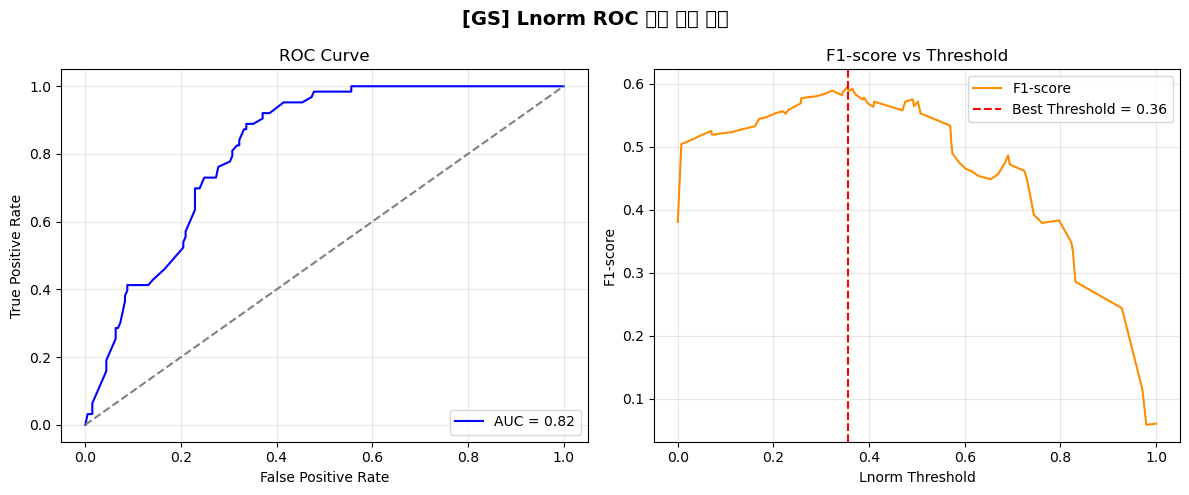


✅ [GS] 결과 요약
Optimal Threshold : 0.356
Accuracy          : 71.64%
F1-score (max)    : 0.596
AUC               : 0.818


C:\Users\speec\AppData\Local\Temp\ipykernel_24320\478478593.py:77: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\speec\AppData\Local\Temp\ipykernel_24320\478478593.py:77: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\speec\AppData\Local\Temp\ipykernel_24320\478478593.py:77: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\speec\AppData\Local\Temp\ipykernel_24320\478478593.py:77: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\speec\AppData\Local\Temp\ipykernel_24320\478478593.py:77: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\speec\AppData\Local\Temp\ipykernel_24320\478478593.py:77: UserWarning: Glyph 49437 (\N{HANGUL SYLLABLE SEOG}) missing from 

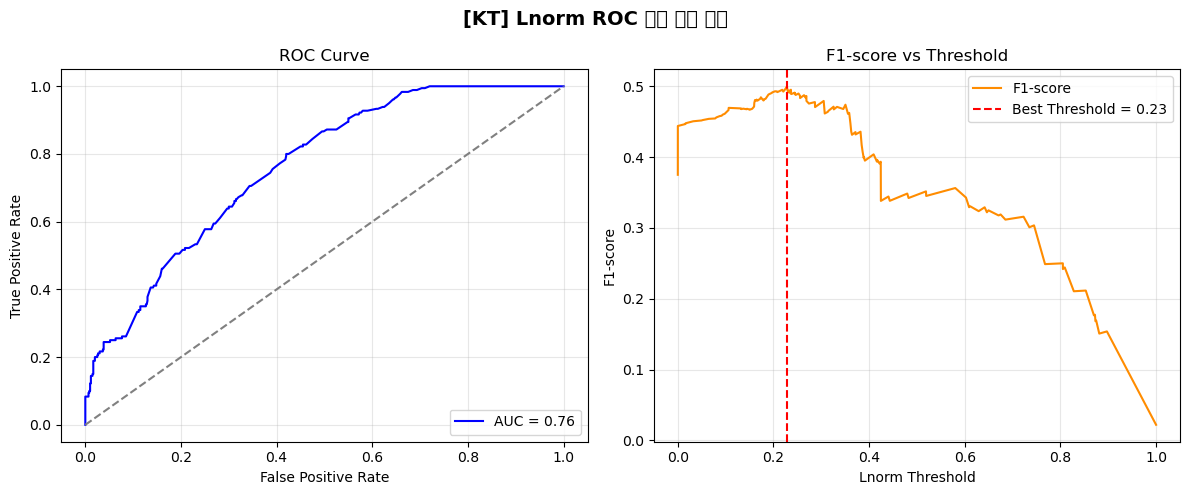


✅ [KT] 결과 요약
Optimal Threshold : 0.228
Accuracy          : 63.08%
F1-score (max)    : 0.500
AUC               : 0.760


C:\Users\speec\AppData\Local\Temp\ipykernel_24320\478478593.py:77: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\speec\AppData\Local\Temp\ipykernel_24320\478478593.py:77: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\speec\AppData\Local\Temp\ipykernel_24320\478478593.py:77: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\speec\AppData\Local\Temp\ipykernel_24320\478478593.py:77: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\speec\AppData\Local\Temp\ipykernel_24320\478478593.py:77: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\speec\AppData\Local\Temp\ipykernel_24320\478478593.py:77: UserWarning: Glyph 49437 (\N{HANGUL SYLLABLE SEOG}) missing from 

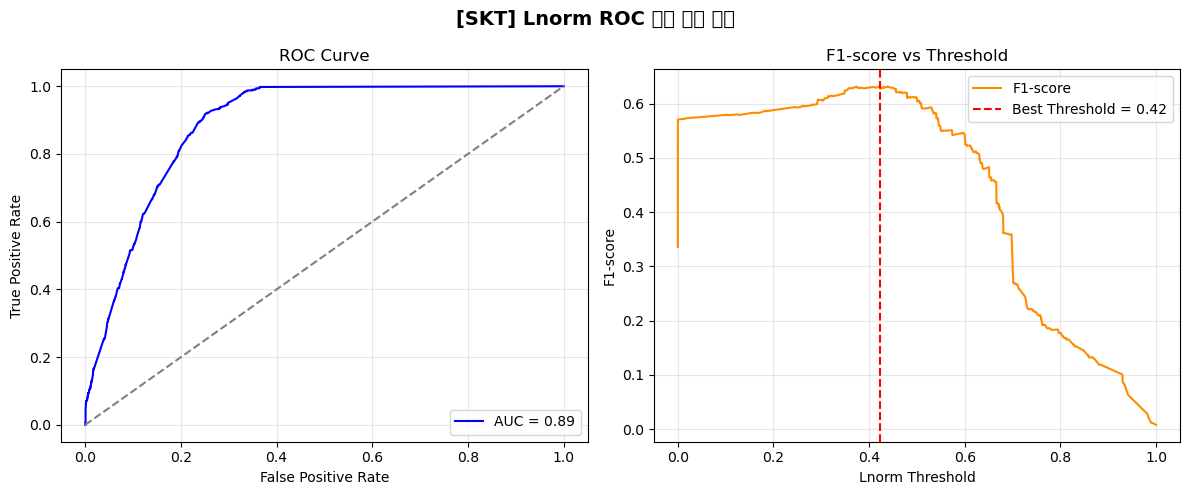


✅ [SKT] 결과 요약
Optimal Threshold : 0.423
Accuracy          : 79.01%
F1-score (max)    : 0.632
AUC               : 0.888


C:\Users\speec\AppData\Local\Temp\ipykernel_24320\478478593.py:77: UserWarning: Glyph 47215 (\N{HANGUL SYLLABLE ROS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\speec\AppData\Local\Temp\ipykernel_24320\478478593.py:77: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\speec\AppData\Local\Temp\ipykernel_24320\478478593.py:77: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\speec\AppData\Local\Temp\ipykernel_24320\478478593.py:77: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\speec\AppData\Local\Temp\ipykernel_24320\478478593.py:77: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\speec\AppData\Local\Temp\ipykernel_24320\478478593.py:77: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from fo

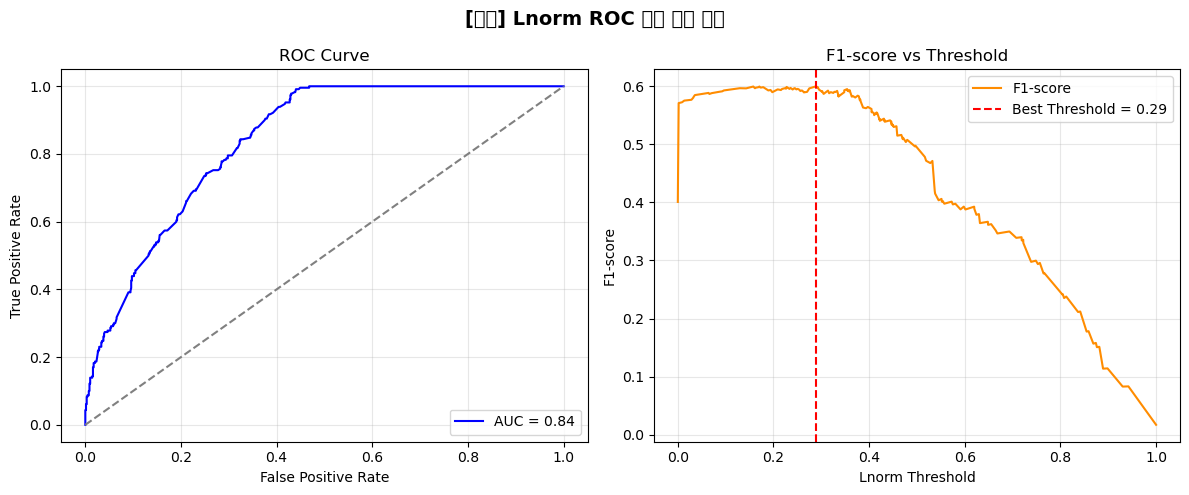


✅ [롯데] 결과 요약
Optimal Threshold : 0.289
Accuracy          : 71.79%
F1-score (max)    : 0.600
AUC               : 0.837

📊 4개 기업별 ROC 기반 평가 요약
  company  threshold  accuracy  f1_score       auc
0      GS   0.355781  0.716418  0.595745  0.817886
1      KT   0.228347  0.630769  0.500000  0.760171
2     SKT   0.422555  0.790083  0.631884  0.887670
3      롯데   0.289397  0.717865  0.599691  0.837351


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc

# ------------------------------------------------------------
# 1️⃣ 데이터 불러오기 및 평가
# ------------------------------------------------------------
company_list = ["GS", "KT", "SKT", "롯데"]
results = []

for company in company_list:
    file_path = rf"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\{company}_final_merged_L_Lnorm_E_T.xlsx"
    df = pd.read_excel(file_path)
    
    # 결측값 처리
    df["comment_cnt"] = df["comment_cnt"].fillna(0)
    df["aligned_cnt_3h"] = df["aligned_cnt_3h"].fillna(0)
    df["Lnorm"] = df["Lnorm"].fillna(0)

    # ------------------------------------------------------------
    # 2️⃣ 실제 영향력(댓글 + 3시간 감정일치)
    # ------------------------------------------------------------
    df["Impact_true"] = df["comment_cnt"] + df["aligned_cnt_3h"]
    thr_true = df["Impact_true"].quantile(0.8)
    df["y_true"] = (df["Impact_true"] >= thr_true).astype(int)

    # ------------------------------------------------------------
    # 3️⃣ ROC 기반 F1 최대점 탐색
    # ------------------------------------------------------------
    y_true = df["y_true"].values
    y_score = df["Lnorm"].values

    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    f1_scores = [f1_score(y_true, (y_score >= t).astype(int)) for t in thresholds]

    best_idx = np.argmax(f1_scores)
    best_thr = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    df["y_pred"] = (df["Lnorm"] >= best_thr).astype(int)
    acc = accuracy_score(y_true, df["y_pred"])
    auc_score = auc(fpr, tpr)

    results.append({
        "company": company,
        "threshold": best_thr,
        "accuracy": acc,
        "f1_score": best_f1,
        "auc": auc_score
    })

    # ------------------------------------------------------------
    # 4️⃣ 시각화: ROC Curve + F1 vs Threshold
    # ------------------------------------------------------------
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"[{company}] Lnorm ROC 기반 성능 분석", fontsize=14, fontweight='bold')

    # (1) ROC Curve
    ax[0].plot(fpr, tpr, color='blue', label=f"AUC = {auc_score:.2f}")
    ax[0].plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax[0].set_xlabel("False Positive Rate")
    ax[0].set_ylabel("True Positive Rate")
    ax[0].set_title("ROC Curve")
    ax[0].legend(loc="lower right")
    ax[0].grid(alpha=0.3)

    # (2) F1 vs Threshold Curve
    ax[1].plot(thresholds, f1_scores, color='darkorange', label="F1-score")
    ax[1].axvline(best_thr, color='red', linestyle='--', label=f"Best Threshold = {best_thr:.2f}")
    ax[1].set_xlabel("Lnorm Threshold")
    ax[1].set_ylabel("F1-score")
    ax[1].set_title("F1-score vs Threshold")
    ax[1].legend(loc="best")
    ax[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------
    # 5️⃣ 결과 출력
    # ------------------------------------------------------------
    print(f"\n✅ [{company}] 결과 요약")
    print(f"Optimal Threshold : {best_thr:.3f}")
    print(f"Accuracy          : {acc:.2%}")
    print(f"F1-score (max)    : {best_f1:.3f}")
    print(f"AUC               : {auc_score:.3f}")

# ------------------------------------------------------------
# 6️⃣ 전체 결과 요약
# ------------------------------------------------------------
results_df = pd.DataFrame(results)
print("\n📊 4개 기업별 ROC 기반 평가 요약")
print(results_df)


📍 F1 최대점 기준
Optimal Threshold : 0.356
F1-score (max)     : 0.596
Accuracy (at best) : 71.64%


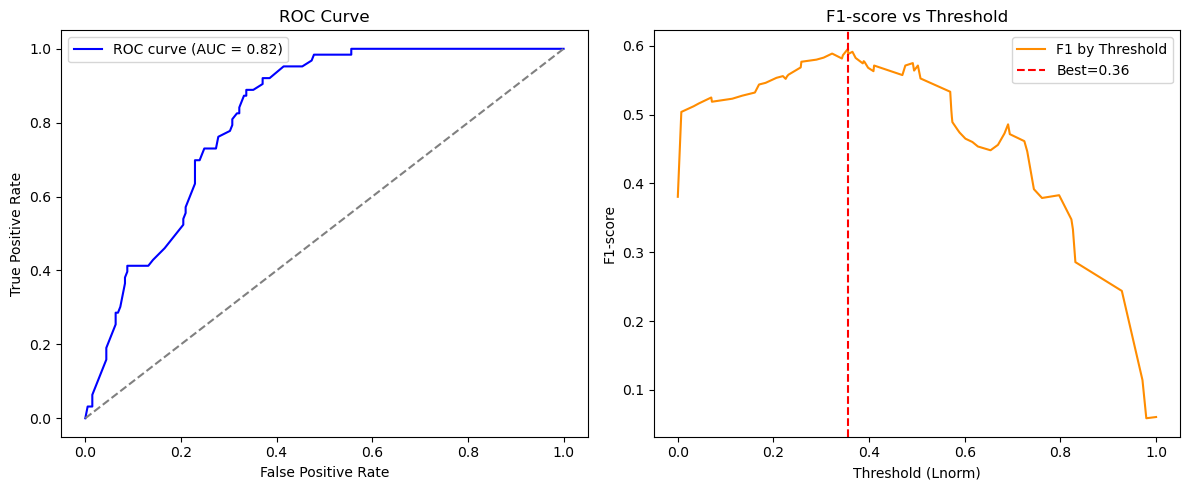

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, roc_curve, auc

# ------------------------------------------------------------
# 1️⃣ 실제 y_true (댓글 + 3시간 공감 기반) / 예측 Lnorm
# ------------------------------------------------------------
# 예시: df["y_true"] = 실제 영향력 여부, df["Lnorm"] = 예측 점수(0~1)
y_true = df["y_true"]
y_score = df["Lnorm"]

# ------------------------------------------------------------
# 2️⃣ ROC 커브 계산 (TPR, FPR)
# ------------------------------------------------------------
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# ------------------------------------------------------------
# 3️⃣ F1-score를 각 threshold마다 계산
# ------------------------------------------------------------
f1_scores = [f1_score(y_true, (y_score >= thr).astype(int)) for thr in thresholds]
best_idx = np.argmax(f1_scores)
best_thr = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

# ------------------------------------------------------------
# 4️⃣ 최적 threshold로 Accuracy도 계산
# ------------------------------------------------------------
y_pred_opt = (y_score >= best_thr).astype(int)
acc = accuracy_score(y_true, y_pred_opt)

print(f"📍 F1 최대점 기준")
print(f"Optimal Threshold : {best_thr:.3f}")
print(f"F1-score (max)     : {best_f1:.3f}")
print(f"Accuracy (at best) : {acc:.2%}")

# ------------------------------------------------------------
# 5️⃣ ROC 커브 시각화 + F1-score 변화 그래프
# ------------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(12,5))

# --- (1) ROC Curve ---
ax[0].plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
ax[0].plot([0, 1], [0, 1], color='gray', linestyle='--')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('ROC Curve')
ax[0].legend()

# --- (2) F1 vs Threshold Curve ---
ax[1].plot(thresholds, f1_scores, color='darkorange', label='F1 by Threshold')
ax[1].axvline(best_thr, color='red', linestyle='--', label=f'Best={best_thr:.2f}')
ax[1].set_xlabel('Threshold (Lnorm)')
ax[1].set_ylabel('F1-score')
ax[1].set_title('F1-score vs Threshold')
ax[1].legend()

plt.tight_layout()
plt.show()


파란선(ROC Curve)은 임계값(threshold)을 바꾸면서 계산한 재현율(True Positive Rate) 과 오탐율(False Positive Rate) 의 관계를 보여줌.

회색 점선은 “무작위 예측(50%)”을 의미.

파란선이 이 점선보다 위로 높게 휘어질수록 모델이 잘 구분하고 있다는 뜻.

이 곡선 아래 면적(AUC, Area Under Curve)이 0.82로,
→ Lnorm이 82% 수준의 구분 정확도(분류력) 을 가지고 있다는 의미야.
→ 즉, “영향력 있는 콘텐츠(1)”와 “없는 콘텐츠(0)”를 꽤 안정적으로 구분하고 있다.0.36

주황색 곡선은 threshold를 0.0~1.0까지 바꾸면서 계산한 F1-score 변화.

F1-score는 정밀도(Precision) 와 재현율(Recall) 의 균형 지표로,
값이 높을수록 “영향력 콘텐츠를 정확하게 잡았다”는 뜻이야.

빨간 점선은 F1이 가장 높아지는 지점(최적 기준점) 을 의미.
→ 이 데이터에서는 Lnorm = 0.36이 최적 기준.
→ 즉, 0.36 이상이면 “영향력 있음(1)”으로 분류하는 게 가장 정확했음.

이때의 F1-score가 약 0.6, Accuracy(정확도)가 약 71.6%로 계산됨.